In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import sys
sys.path.append("../")

In [3]:

from dataclasses import replace
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, cdist
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings

In [4]:
# model_checkpoint = "../out/ce_model_phoneme_within_word_prefix_6_32/checkpoint-600"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
model_checkpoint = "../out/ce_model_phoneme_6_32/checkpoint-800/"
equiv_dataset_path = "../data/timit_equiv_phoneme_1.pkl"

state_space_spec_path = "../out/state_space_specs/all_words.pkl"

metric = "cosine"

In [5]:
model = ContrastiveEmbeddingModel.from_pretrained(model_checkpoint)
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=32, bias=True)
  )
)

In [6]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [7]:
with open(state_space_spec_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = pickle.load(f)
assert state_space_spec.is_compatible_with(equiv_dataset)

In [8]:
model_representations = compute_embeddings(model, equiv_dataset,
                                           device="cpu")
model_representations = model_representations.numpy()

  0%|          | 0/4740 [00:00<?, ?it/s]

In [9]:
pca = PCA(n_components=2)
model_representations_pca = pca.fit_transform(model_representations)

In [10]:
# Retain only words with N or more instances
retain_n = 3
retain_idxs = [idx for idx, target_frames in enumerate(state_space_spec.target_frame_spans)
               if len(target_frames) >= retain_n]
state_space_spec = replace(state_space_spec,
    labels=[state_space_spec.labels[i] for i in retain_idxs],
    target_frame_spans=[state_space_spec.target_frame_spans[i] for i in retain_idxs],
)

In [11]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec)

In [12]:
len(trajectory)

206

In [67]:
def get_mean_distance(samp1, samp2, metric=None):
    distances = cdist(samp1, samp2, metric=metric)
    distances = distances[[(i, j) for i, j in np.ndindex(distances.shape) if i > j]]
    return distances.mean()

## Estimate within-word distance

In [68]:
within_distance = np.zeros((len(trajectory), trajectory[0].shape[1]))
for i, trajectory_i in enumerate(tqdm(trajectory)):
    within_distance_i = []
    num_instances, num_frames, num_dims = trajectory_i.shape
    for j in range(num_frames):
        within_distance[i, j] = get_mean_distance(trajectory_i[:, j, :], trajectory_i[:, j, :], metric=metric)

  0%|          | 0/206 [00:00<?, ?it/s]

<Axes: >

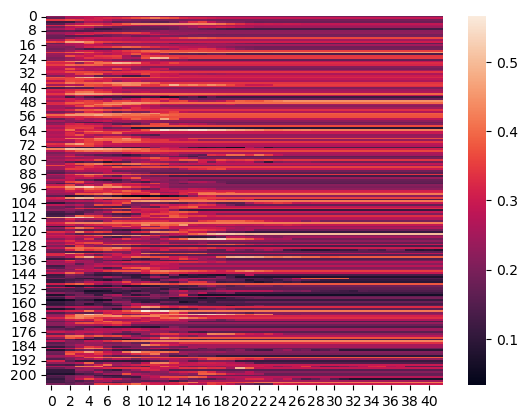

In [69]:
sns.heatmap(within_distance)

In [70]:
within_distance_df = pd.DataFrame(within_distance, index=pd.Index(state_space_spec.labels, name="word")) \
    .reset_index() \
    .melt(id_vars=["word"], var_name="frame", value_name="distance")

<Axes: xlabel='frame', ylabel='distance'>

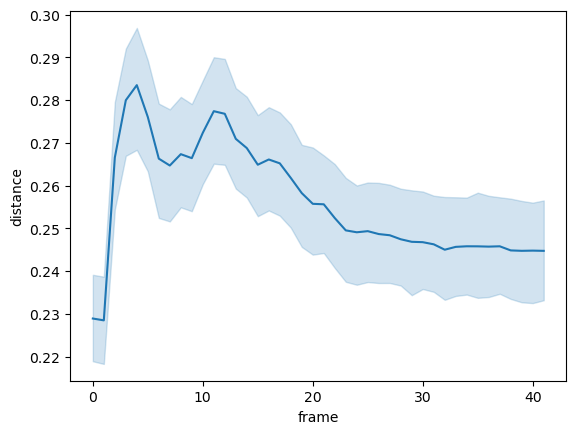

In [71]:
sns.lineplot(data=within_distance_df, x="frame", y="distance")

## Estimate between-word distance

In [72]:
num_samples = 50
between_samples = [np.random.choice(list(range(idx)) + list(range(idx + 1, len(trajectory))),
                                    num_samples, replace=False)
                   for idx in range(len(trajectory))]
between_distances = np.zeros((len(trajectory), trajectory[0].shape[1], num_samples))
for i, between_samples_i in enumerate(tqdm(between_samples)):
    for j, between_sample in enumerate(between_samples_i):
        for k in range(trajectory[0].shape[1]):
            between_distances[i, k, j] = get_mean_distance(trajectory[i][:, k, :], trajectory[between_sample][:, k, :], metric=metric).mean()

  0%|          | 0/206 [00:00<?, ?it/s]

In [73]:
between_distances_df = pd.DataFrame(between_distances.mean(axis=-1),
                                    index=pd.Index(state_space_spec.labels, name="word")) \
    .reset_index() \
    .melt(id_vars=["word"], var_name="frame", value_name="distance")

<Axes: xlabel='frame', ylabel='distance'>

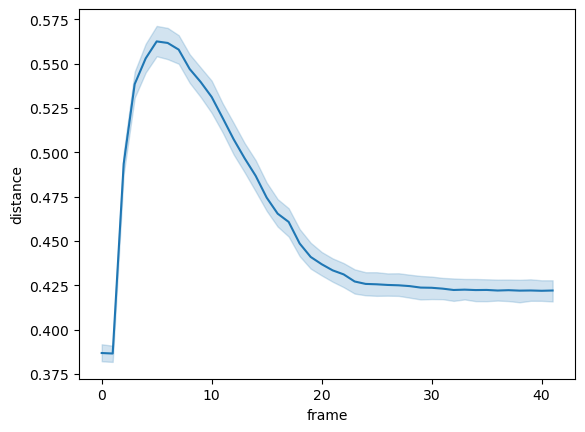

In [74]:
sns.lineplot(data=between_distances_df, x="frame", y="distance")